In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jacobian
from getdist import MCSamples, plots

from tqdm import tqdm

import sys
sys.path.append("../")

from pldflow import plflow

import os
import jax
smoke_test = ('CI' in os.environ)
%matplotlib inline
cpu_device = jax.devices('cpu')[0]

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [82]:
class Fresnel(plflow.PicardLefschetzModelBaseClass):
    ndim = 2
    def action_s(self, z, y, p=1):
        # return 1j*jnp.dot(z-y,z-y)# + p*1j/(1+jnp.dot(z,z))
        return 1j*jnp.dot(z, z) - 2j*jnp.dot(z, y)

## 2D

In [83]:
fresnel = Fresnel()

In [84]:
x1 = jnp.linspace(-3, 3, 400)
x2 = jnp.zeros_like(x1)
x  = jnp.stack([x1, x2], axis=-1)
z = x.astype(jnp.complex64)
s = fresnel.vaction_s(z, 0, 1)
i = fresnel.vintegrand(z, 0, 1)

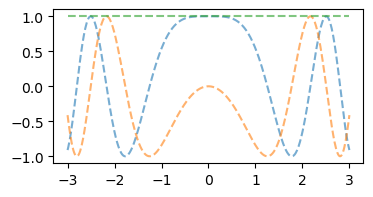

In [85]:
plt.figure(figsize=(4,2))
plt.plot(x1, jnp.real(i)[:,0], ls='--', alpha=0.6)
plt.plot(x1, jnp.imag(i)[:,0], ls='--', alpha=0.6)
plt.plot(x1, jnp.abs(i) [:,0], ls='--', alpha=0.6)
plt.show()

In [86]:
t = jnp.linspace(0, 0.5, 5)
y = jnp.array([0.0, 0.0])
p = jnp.array(1.0)
zt = fresnel.flow(x[0], t, y, p=p)

In [87]:
t = jnp.linspace(0, 0.5, 5)
y = jnp.array([0.0, 0.0])
p = jnp.array(1.0)
%time zt = fresnel.vflow(x, t, y, p=p)
%time zt = fresnel.vflow(x, 5.0, y, p=p)

CPU times: user 113 ms, sys: 5.35 ms, total: 118 ms
Wall time: 121 ms
CPU times: user 78.9 ms, sys: 2.71 ms, total: 81.6 ms
Wall time: 81.3 ms


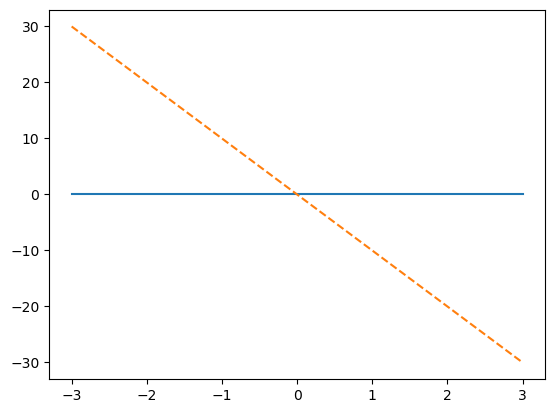

In [88]:
plt.plot(z[:,0].real, z[:,0].imag)
plt.plot(zt[:,0].real, zt[:,0].imag, ls='--')
plt.show()

In [89]:
t = jnp.linspace(0, 0.5, 5)
y = jnp.array([0.0, 0.0])
p = jnp.array(1.0)
%time zt = fresnel.vflow(x, t, y, p=p)

CPU times: user 106 ms, sys: 4.35 ms, total: 111 ms
Wall time: 110 ms


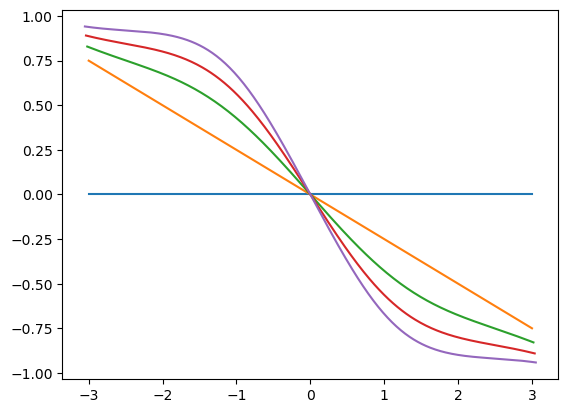

In [90]:
plt.plot(zt[:,:,0].real, zt[:,:,0].imag)
plt.show()

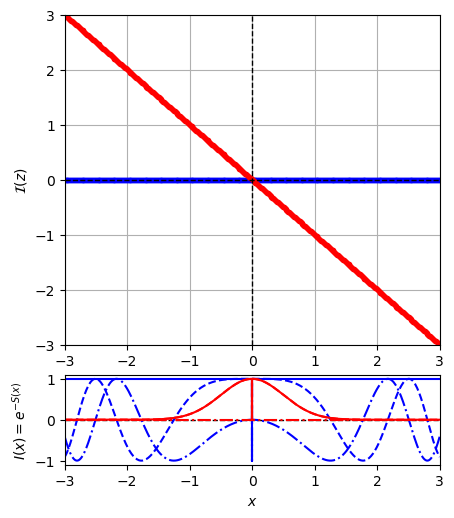

In [91]:
t = jnp.linspace(0, 0.5, 2)
fig, axes = fresnel.plot1d(x, t, y, p=p)

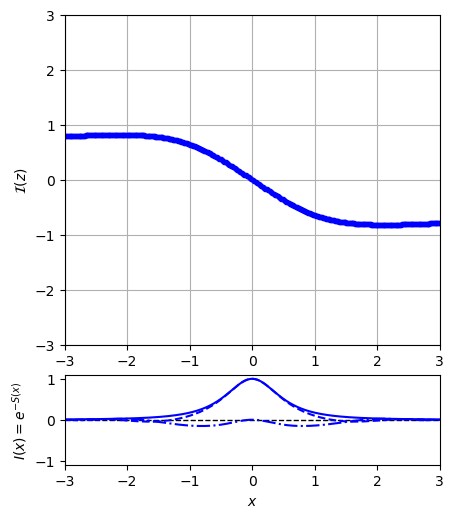

In [92]:
t = jnp.linspace(0, 0.5, 20)
fresnel.plot1dgif("fresnel2D.gif", x,t,y,p=p)

In [93]:
y = jnp.array([0.0,0.0])
p = jnp.array(1)
%time z = fresnel.flow(x[0], 0.1, y, p=p)
%time j = fresnel.flow_jacobian(x[0], 0.1, y, p=p)

CPU times: user 69.6 ms, sys: 6.05 ms, total: 75.6 ms
Wall time: 73.5 ms
CPU times: user 255 ms, sys: 9.06 ms, total: 264 ms
Wall time: 271 ms


In [94]:
%time z = fresnel.vflow(x, 0.1, y, p=p)
%time j = fresnel.vflow_jacobian(x, 0.1, y, p=p)

CPU times: user 95.6 ms, sys: 5.87 ms, total: 101 ms
Wall time: 99.3 ms
CPU times: user 262 ms, sys: 7.01 ms, total: 269 ms
Wall time: 268 ms


In [95]:
t = jnp.linspace(0, 1.0, 100)
%time z = fresnel.vflow(x, t, y, p=p)
%time j = fresnel.vflow_jacobian(x, t, y, p=p)

CPU times: user 104 ms, sys: 4.98 ms, total: 109 ms
Wall time: 108 ms
CPU times: user 759 ms, sys: 28 ms, total: 787 ms
Wall time: 506 ms


sampling

In [96]:
priors = {'x':(-7,7,2), 'y':(-5,5,2)}
sampler = plflow.HMCSampler(fresnel, priors)

In [97]:
# t = jnp.linspace(0, 0.5, 20)
t = jnp.linspace(0, 0.4, 100)
sampler.sample(num_samples=10000, t=t)

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
  0%|          | 0/10500 [00:00<?, ?it/s]/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|██████████| 10500/10500 [00:08<00:00, 1281.13it/s, 31 steps of size 1.56e-01. acc. prob=0.77]


In [98]:
mcs = sampler.get_samples(format=MCSamples)

Removed no burn in


<Figure size 400x400 with 0 Axes>

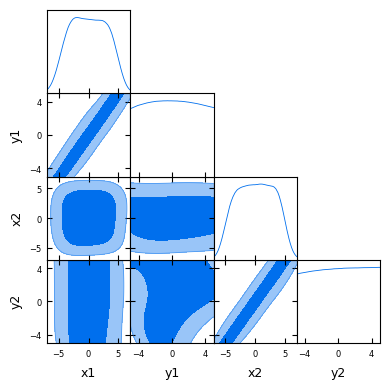

In [99]:
g = plots.get_single_plotter(ratio=1, width_inch=4)
g.triangle_plot(mcs, ['x1', 'y1', 'x2', 'y2'], filled=True)
plt.show()

normalizing flow

In [100]:
maf = plflow.MAFModel(sampler)

In [101]:
maf.build(hidden_dims=[64,64,64], n_transforms=8)

In [102]:
%time maf.train(n_steps=1_000, batch_size=128)

Training MAF: 100%|██████████| 1000/1000 [00:20<00:00, 48.44it/s]

CPU times: user 21.8 s, sys: 1.59 s, total: 23.4 s
Wall time: 22.2 s


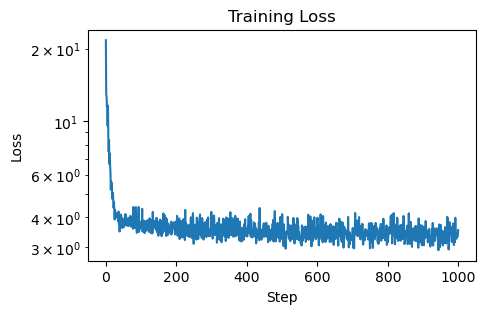

In [103]:
maf.plot_loss()

In [104]:
y = jnp.array([4.0, 0.0])
%time x = maf.sample(y, num_samples=10000, seed=5)
%time lnp = maf.log_prob(x, y)

CPU times: user 606 ms, sys: 48 ms, total: 654 ms
Wall time: 588 ms
CPU times: user 507 ms, sys: 48.4 ms, total: 556 ms
Wall time: 418 ms


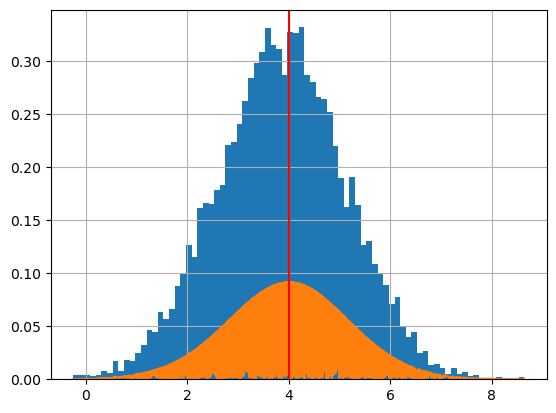

In [105]:
a = jnp.argsort(x[:,0])
plt.hist(x[a,0], bins=80, density=True)
plt.plot(x[a,0], jnp.exp(lnp[a]))
plt.axvline(y[0], color='r')
plt.grid()
plt.show()

In [106]:
t = jnp.linspace(0, 1.0, 20)
y = jnp.array([4.0, 0.0])
x = maf.sample(y, num_samples=1000, seed=0, beta=2.0)
lnp = maf.log_prob(x, y)
%time Z = fresnel.integrate(x, lnp, t, y=y)

CPU times: user 513 ms, sys: 14.7 ms, total: 527 ms
Wall time: 673 ms


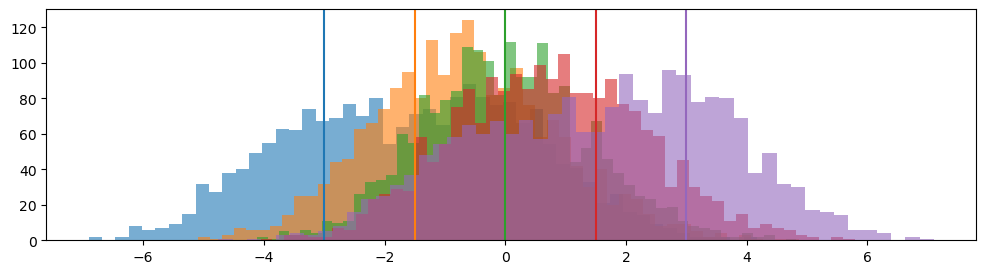

In [109]:
y1 = jnp.linspace(-3, 3, 5)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1, y2], axis=-1)
plt.figure(figsize=(12, 3))
for i, _y in enumerate(y):
    x = maf.sample(_y, num_samples=1000, seed=0)
    color = f"C{i}"
    plt.hist(x.ravel(), bins=50, density=False, alpha=0.6, color=color)
    plt.axvline(_y[0], color=color)
plt.show()

In [110]:
y1 = jnp.linspace(-3, 3, 100)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1, y2], axis=-1)

# t = jnp.linspace(0, 0.5, 20)
t = jnp.linspace(0, 0.4, 100)

Z = []
for _y in tqdm(y):
    x = maf.sample(_y, num_samples=1000, seed=0, beta=1.0)
    lnp = maf.log_prob(x, _y, beta=1.0)
    _Z = fresnel.integrate(x, lnp, t, y=_y)
    Z.append(_Z)
Z = jnp.array(Z)

100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


In [111]:
ndim = fresnel.ndim
Z_ana = jnp.exp(1j*y1**2) * ((1-1j)*jnp.sqrt(jnp.pi/2.0))**ndim

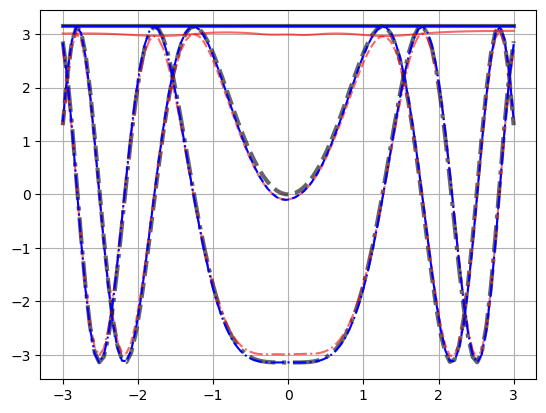

In [112]:
# analytic
plt.plot(y1, jnp.real(Z_ana), color='k', ls='--', alpha=0.6, lw=3)
plt.plot(y1, jnp.imag(Z_ana), color='k', ls='-.', alpha=0.6, lw=3)
plt.plot(y1, jnp.abs(Z_ana) , color='k', ls='-' , alpha=0.6, lw=3)
# estimate
plt.plot(y1, jnp.real(Z), color='r', ls='--', alpha=0.6)
plt.plot(y1, jnp.imag(Z), color='r', ls='-.', alpha=0.6)
plt.plot(y1, jnp.abs(Z) , color='r', ls='-' , alpha=0.6)
# abs corrected
norm = jnp.abs(Z)/jnp.abs(Z_ana)
plt.plot(y1, jnp.real(Z)/norm, color='b', ls='--')
plt.plot(y1, jnp.imag(Z)/norm, color='b', ls='-.')
plt.plot(y1, jnp.abs(Z) /norm, color='b', ls='-')
plt.grid()
plt.show()

In [114]:
y = jnp.array([1.0, 0.0])
x = maf.sample(y, num_samples=1000, seed=0, beta=2.0)
lnp = maf.log_prob(x, y)
z = fresnel.vflow(x, t, uselast=True, y=y)
ix = fresnel.vintegrand(x, y)
iz = fresnel.vintegrand(z, y)
j  = fresnel.vflow_jacobian(x, t, y=y, uselast=True)
print(jnp.mean(iz*j*jnp.exp(-lnp)))

(8.458997-3.4980597j)


/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


28.47746


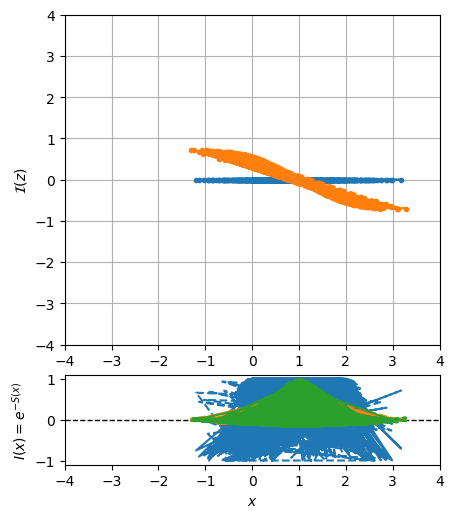

In [115]:
fig, axes = fresnel._plot1d_template()
a = jnp.argsort(x.ravel())
axes[0].plot(x[a,0].real, x[a,0].imag, ls='-', marker='.')
axes[0].plot(z[a,0].real, z[a,0].imag, ls='--', marker='.')
axes[0].set_xlim(-4,4)
axes[0].set_ylim(-4,4)
axes[1].plot(x[a,0], ix[a].real, 'C0')
axes[1].plot(x[a,0], ix[a].imag, 'C0--')
axes[1].plot(z[a,0], iz[a].real, 'C1-')
axes[1].plot(z[a,0], iz[a].imag, 'C1--')
pp = iz*j*jnp.exp(-lnp)
pm = pp.real.max()
print(pm)
axes[1].plot(z[a,0], (pp/pm)[a].real, 'C2-')
axes[1].plot(z[a,0], (pp/pm)[a].imag, 'C2--')
plt.show()

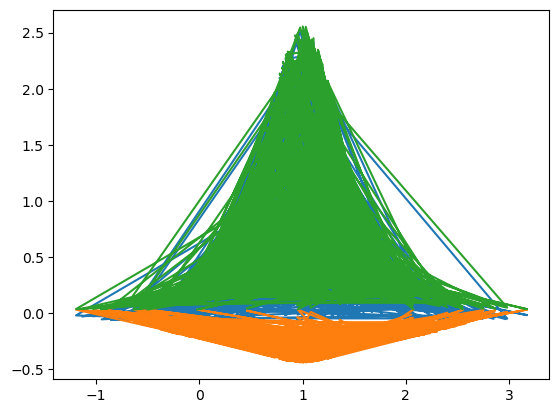

(0.6836028-0.2557247j)
(0.6836028-0.2557247j)
(0.6836028-0.2557247j)


In [116]:
ii = iz*j #* jnp.exp(-lnp)
plt.plot(x[a,0], ii[a].real, 'C0')
plt.plot(x[a,0], ii[a].imag, 'C1')
plt.plot(x[a,0], jnp.abs(ii[a]), 'C2')
# plt.plot(x[a,0], jnp.abs(j[a]), 'C2')
# plt.plot(x[a,0][lnp > jnp.log(1e-2)], ii[a][lnp > jnp.log(1e-2)].real, 'red', ls='--', marker='.')
plt.show()

print(jnp.mean(ii))
print(jnp.mean(ii[lnp>jnp.log(1e-2)]))
print(jnp.mean(ii[lnp>jnp.log(1e-3)]))


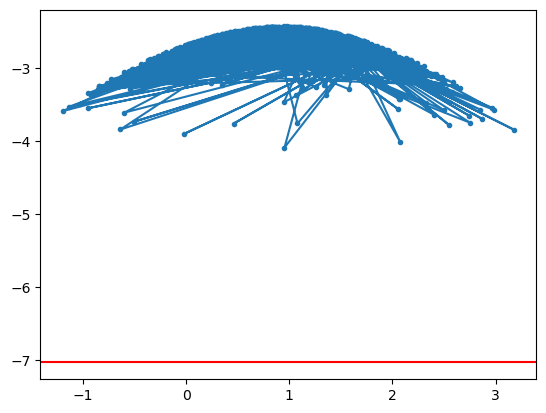

In [117]:
plt.plot(x[a,0], lnp[a], marker='.')
plt.axhline(lnp.max()+jnp.log(1e-2), color='r')
plt.show()